In [2]:
import numpy as np
import PIL.Image
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
DEVICE = "cuda"
EPISODE = 100
model = models.vgg19(pretrained=True).features.eval().requires_grad_(False).to(DEVICE)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)
preprocess = T.Compose([
        T.ToPILImage(),
        T.Resize(512),
        T.CenterCrop(512),
        T.ToTensor(),
        # T.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
    ])

show = T.ToPILImage()

def imageProcess(path):
    image = (preprocess(plt.imread(path))).to(DEVICE)
    return image

def Grim_Maxtrix(input):
    s = input.shape
    a, b, c, d = s[0], s[1], s[2], s[3]     # a为图片数，b为通道数，c和d分别为宽高
    F = input.resize(b, c*d)       # 先算F
    G = F@F.T               # 再算外积(叉乘)
    return torch.div(G, 2*b*c*d)

class ContentLoss(nn.Module):
    def __init__(self, content):
        super(ContentLoss, self).__init__()
        self.content = content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(self.content, x)
        return x

class StyleLoss(nn.Module):
    def __init__(self, style):
        super(StyleLoss, self).__init__()
        self.style = Grim_Maxtrix(style).detach()

    def forward(self, x):
        x_ = Grim_Maxtrix(x)
        self.loss = F.mse_loss(self.style, x_)
        return x

class Normolization(nn.Module):
    def __init__(self, mean, std):
        super(Normolization, self).__init__()
        self.mean = mean.view(-1,1,1)
        self.std = std.view(-1,1,1)

    def forward(self, input):
        nor = (input-self.mean)/self.std
        return nor


In [3]:
style_image = imageProcess("style_img/escher.jpg").unsqueeze(0).to(DEVICE).requires_grad_(False)
content_image = imageProcess("content_img/tower.jpg").unsqueeze(0).to(DEVICE).requires_grad_(False)
target_image = content_image.clone()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


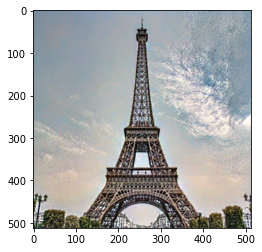

In [85]:
# plt.imshow((target_image.squeeze(0).cpu().detach()).reshape(512,512,3))   # 错的，reshape有误，展示出来是9张一样的灰度图
plt.imshow((target_image.squeeze(0).cpu().detach()).permute(1,2,0))

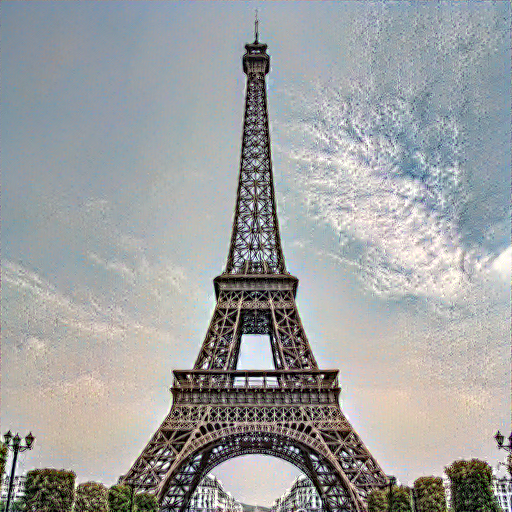

In [78]:
show = T.ToPILImage()
show(target_image.squeeze(0))

In [5]:
# style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
# content_layers = ['conv4_2']
# Loop through vgg layers
style_losses = []
content_losses = []
nor = Normolization(cnn_normalization_mean, cnn_normalization_std).to(DEVICE)
self_model = nn.Sequential().to(DEVICE)
self_model.add_module("normalize", nor)

# i = 0
# block = 0
# for layer in model.children():
#     name = ""
#     if isinstance(layer, nn.Conv2d):
#         if (list(layer.parameters())[0].shape[0] != list(layer.parameters())[0].shape[1]) or i == 5:
#             block += 1
#             i = 0
#         i += 1
#         name = 'conv{}_{}'.format(block, i)
#     elif isinstance(layer, nn.ReLU):
#         name = 'relu{}_{}'.format(block, i)
#         layer = nn.ReLU(inplace=False).to(DEVICE)
#     elif isinstance(layer, nn.MaxPool2d):
#         name = 'pool{}_{}'.format(block, i)
#         layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False).to(DEVICE)
#     elif isinstance(layer, nn.BatchNorm2d):
#         name = 'bn{}_{}'.format(block, i)
#
#     # Add layer to our model
#     self_model.add_module(name, layer)
#     # Insert style loss layer
#     if name in style_layers:
#         target_feature = self_model(style_image).detach()
#         style_loss = StyleLoss(target_feature).to(DEVICE)
#         self_model.add_module('style_loss_{}'.format(block), style_loss)
#         style_losses.append(style_loss)
#     # Insert content loss layer
#     if name in content_layers:
#         target = self_model(content_image).detach()
#         content_loss = ContentLoss(target).to(DEVICE)
#         self_model.add_module('content_loss_{}'.format(block), content_loss)
#         content_losses.append(content_loss)
# idx = 0
# for i in range(len(self_model)-1, 0, -1):
#     if isinstance(self_model[i],StyleLoss):
#         idx = i+1
#         break
# self_model = self_model[:idx]

style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layers = ['conv_4']
i = 0
for layer in model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)

    # Add layer to our model
    self_model.add_module(name, layer)

    # Insert style loss layer
    if name in style_layers:
        # print(style_image.shape)
        # print(model)
        target_feature = self_model(style_image).detach()
        style_loss = StyleLoss(target_feature)
        self_model.add_module('style_loss_{}'.format(i), style_loss)
        style_losses.append(style_loss)

    # Insert content loss layer
    if name in content_layers:
        target = self_model(content_image).detach()
        content_loss = ContentLoss(target)
        self_model.add_module('content_loss_{}'.format(i), content_loss)
        content_losses.append(content_loss)
# Get rid of unneeded layers after our final losses
for i in range(len(self_model) - 1, -1, -1):
    if isinstance(self_model[i], StyleLoss) or isinstance(self_model[i], ContentLoss):
        break
self_model = self_model[:(i + 1)]

D:\ProgramData\Anaconda3\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [6]:
print(self_model)

Sequential(
  (normalize): Normolization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (content_loss_4): ContentLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)


In [7]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10000
opt = torch.optim.LBFGS([target_image.requires_grad_(True)])
for i in range(40):
    def closure():
        target_image.data.clamp_(0, 1)  # 消除杂点
        L_content = 0
        L_style = 0
        opt.zero_grad()
        self_model(target_image)

        for i in content_losses:
            L_content += i.loss

        for i in style_losses:
            L_style += i.loss*0.2

        L = CONTENT_WEIGHT*L_content+STYLE_WEIGHT*L_style
        L.backward()
        return L
    opt.step(closure)
    print(i)

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

In [37]:
output = show(target_image.cpu().squeeze(0))
# content = show(content_image.cpu().squeeze(0))
output.save("output/4.jpg")

In [50]:
print(torch.sum(target_image<0))


tensor(7442, device='cuda:0')


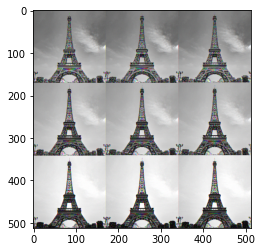

In [11]:
plt.imshow(content_image.view(512,512,3).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


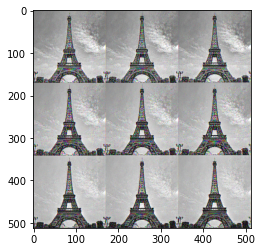

In [13]:
plt.imshow(target_image.view(512,512,3).detach().cpu().numpy())

In [ ]:
a = "123"
len(a)

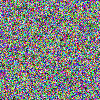

In [63]:
ttt = torch.tensor(np.random.uniform(low=0,high=1,size=(3,100,100)))
show(ttt)

In [57]:
target_image

tensor([[[[ 0.4797,  0.5163,  0.5057,  ...,  0.5276,  0.6802,  0.5233],
          [ 0.4890,  0.4960,  0.4255,  ...,  0.5307,  0.6199,  0.5581],
          [ 0.4734,  0.4390,  0.4354,  ...,  0.5710,  0.4725,  0.6052],
          ...,
          [ 0.3520,  0.2826,  0.1282,  ...,  1.0636,  1.0817,  0.4569],
          [ 0.1398,  0.0592,  0.0054,  ...,  1.0431,  1.0501,  0.6476],
          [ 0.3231,  0.1990,  0.0981,  ...,  1.0749,  0.9933,  0.7005]],

         [[ 0.4332,  0.4968,  0.5473,  ...,  0.4918,  0.7158,  0.5663],
          [ 0.4826,  0.5753,  0.5529,  ...,  0.6296,  0.7220,  0.6188],
          [ 0.5053,  0.5286,  0.5496,  ...,  0.6523,  0.5107,  0.6543],
          ...,
          [ 0.5429,  0.3667,  0.1781,  ...,  1.1079,  0.9840,  0.4675],
          [ 0.2761,  0.0884, -0.0607,  ...,  0.9790,  0.8874,  0.5225],
          [ 0.4791,  0.3151,  0.1773,  ...,  1.0865,  1.0240,  0.5754]],

         [[ 0.5375,  0.5073,  0.5537,  ...,  0.6211,  0.6663,  0.6237],
          [ 0.5514,  0.5460,  